# SMEFiT Tutorial
Author: Jaco ter Hoeve

To run this notebook remotely in Google Colab, click the button below

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/smefit_release/blob/tutorial/tutorial/tutorial.ipynb)

and make sure to click "Copy to drive" at the top to create a copy that you may edit.

### What is SMEFiT? 
SMEFiT is a Python package for global analyses of particle physics data in the framework of the Standard Model Effective Field Theory (SMEFT). The SMEFT represents a powerful model-independent framework to constrain, identify, and parametrize potential deviations with respect to the predictions of the Standard Model (SM). A particularly attractive feature of the SMEFT is its capability to systematically correlate deviations from the SM between different processes. The full exploitation of the SMEFT potential for indirect New Physics searches from precision measurements requires combining the information provided by the broadest possible dataset, namely carrying out extensive global analysis which is the main purpose of SMEFiT.

In case you would like a recap on the basic ideas underlying the SMEFT, see https://lhcfitnikhef.github.io/smefit_release/theory/SMEFT.html

SMEFiT has been used in the following publications

- *A Monte Carlo global analysis of the Standard Model Effective Field Theory: the top quark sector*, N. P. Hartland, F. Maltoni, E. R. Nocera, J. Rojo, E. Slade, E. Vryonidou, C. Zhang.
- *Constraining the SMEFT with Bayesian reweighting*, S. van Beek, E. R. Nocera, J. Rojo, and E. Slade.
- *SMEFT analysis of vector boson scattering and diboson data from the LHC Run II* , J. Ethier, R. Gomez-Ambrosio, G. Magni, J. Rojo.
- *Combined SMEFT interpretation of Higgs, diboson, and top quark data from the LHC*, J. Ethier, G.Magni, F. Maltoni, L. Mantani, E. R. Nocera, J. Rojo, E. Slade, E. Vryonidou, C. Zhang .
- *The automation of SMEFT-assisted constraints on UV-complete models*, J. ter Hoeve, G. Magni, J. Rojo, A. N. Rossia, E. Vryonidou .
- *Mapping the SMEFT at High-Energy Colliders: from LEP and the (HL-)LHC to the FCC-ee*, E.Celada, T. Giani, J. ter Hoeve, L. Mantani, J. Rojo, A. N. Rossia, M. O. A. Thomas, E. Vryonidou.

### Exercise  0 - Installing SMEFiT

First things first, let us install SMEFiT:

In [ ]:
!pip install smefit

Note to google colab users, you may ignore the error related to pandas in case it shows up. 

For the purpose of this tutorial, we also need the following additional packages

In [ ]:
!pip install wget
import sys
import os
import wget
import subprocess
import pathlib
import yaml
import matplotlib as mpl
from IPython.display import Image

mpl.rcParams.update(mpl.rcParamsDefault)

In [7]:
import smefit
import smefit.runner
from smefit.analyze.report import Report

smefit.log.setup_console(None)

Download the smefit datasets and runcards

In [ ]:
def file_downloader(url, download_dir='./downloads'):

    if not os.path.exists(download_dir):
        os.mkdir(download_dir)

    file = wget.download(url, out=download_dir)
    return file

smefit_database = file_downloader('https://github.com/LHCfitNikhef/smefit_database/archive/refs/heads/main.zip')
runcards = file_downloader('https://github.com/LHCfitNikhef/smefit_release/raw/tutorial/tutorial/runcards.zip')

subprocess.run([f"unzip {smefit_database} -d ./downloads"], capture_output=False, shell=True, text=False)
subprocess.run([f"unzip {runcards} -d ./downloads"], capture_output=False, shell=True, text=False)

### Exercise 1 - Our first fit with SMEFiT

In this first exercise, we will study the relative impact of various datasets on a two-dimensional SMEFT parameter space. Consider the four-fermion Wilson coefficients $c_{Qq}^{1, 8}$ and $c_{Qq}^{3,8}$, defined as

$$
\begin{align}
c_{Qq}^{1,8} &= c_{qq}^{1(i33i)} + 3 c_{qq}^{3(i33i)} \\
c_{Qq}^{3,8} &= c_{qq}^{1(i33i)} - c_{qq}^{3(i33i)} \, ,
\end{align}
$$

with the corresponding operators on the RHS given by

$$
\begin{align}
\mathcal{O}_{qq}^{1(i33i)} &= \left(\bar{q}_i\gamma^\mu Q \right)\left(\bar{Q} \gamma_\mu q_i\right) \\
\mathcal{O}_{qq}^{3(i33i)} &= \left(\bar{q}_i\gamma^\mu \tau^I Q \right)\left(\bar{Q} \gamma_\mu \tau^I q_l\right) \, .
\end{align}
$$

Here the fields $q_i$ and $Q$ constitute respectively the light ($i=1,2$) and heavy quark $SU(2)$ doublets, while the $\tau^I$ are the usual Pauli matrices.

**Question 1A**
- Do $\mathcal{O}_{qq}^{1(ijkl)}$ and $\mathcal{O}_{qq}^{3(ijkl)}$ define valid SMEFT operators at dimension-six? If so, why?

These operators modify SM processes measured at the LHC, and hence provide a probe to study possible new physics beyond the SM. The goal of the rest of this exercise is to set bounds on the corresponding Wilson coefficients to check whether current data is compatible with the SM or not.

**Question 1B**
- Consider top-pair production in association with a Z or W boson. Convince yourself by drawing a representative Feynman diagram that the operators defined above modify $ttV$ ($V=W, Z)$ production.

To run the fit, we need a runcard. An example is given below. In this first exercise we will provide all runcards, so no need to write them yourself. 

```yaml
# smefit_runcard.yaml

# name to give to fit
result_ID: ttV

# path where results are stored
result_path: ./results

# path to data
data_path: ./downloads/smefit_database-main/commondata

# path to theory tables
theory_path: ./downloads/smefit_database-main/theory

# perturbatve QCD order (LO or NLO)
order: NLO

# include theory uncertainties
use_theory_covmat: True
use_t0: True

# SMEFT Expansion Order (NHO = Lambda^-2 , HO = Lambda^-4)
use_quad: False

# number of samples
n_samples: 20000


# Datasets to include
datasets:

  - CMS_ttZ_13TeV
  - CMS_ttZ_13TeV_pTZ
  - CMS_ttZ_8TeV
  - ATLAS_ttZ_13TeV
  - ATLAS_ttZ_13TeV_2016
  - ATLAS_ttZ_13TeV_pTZ
  - ATLAS_ttZ_8TeV
  - CMS_ttW_13TeV
  - CMS_ttW_8TeV
  - ATLAS_ttW_13TeV
  - ATLAS_ttW_13TeV_2016
  - ATLAS_ttW_8TeV


# Coefficients to fit
coefficients:

  O81qq: { 'min': -2, 'max': 2 }
  O83qq: { 'min': -2, 'max': 2 }
```

The datasets entry shows which datasets enter the fit, and the coefficients to be fitted are the four-fermion operators we defined earlier. We are now ready to run our first linear fit.  

In [ ]:
runner_ttV = smefit.runner.Runner.from_file(pathlib.Path("./downloads/runcards/runcard_ttV.yaml"))
runner_ttV.global_analysis("A")

The fit should have finished, and the 95% exclusion contour can now be displayed by

In [14]:
def make_report(runcard_report):

    with open(runcard_report, encoding="utf-8") as f:
        report_config = yaml.safe_load(f)
    
    report_name = report_config["name"]
    report_path = pathlib.Path(report_config["report_path"]).absolute()
    report_folder = report_path.joinpath(f"{report_name}")

    report_folder.mkdir(exist_ok=True, parents=True)

    report = Report(report_path, report_config["result_path"], report_config)
    
    report.coefficients(**report_config["coefficients_plots"])

In [ ]:
make_report("./downloads/runcards/runcard_report_ttV.yaml")

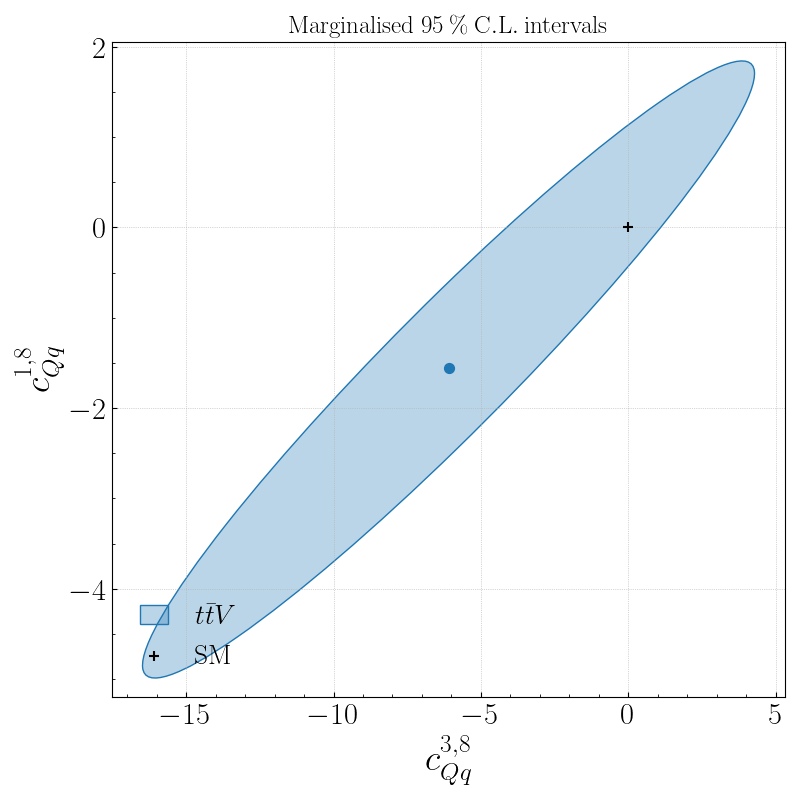

In [48]:
# show the exclusion contour
Image(filename='./reports/report_ttV/contours_2d.png') 

**Question 1C**

- What special behaviour do you observe between the two operators?
- What options do we have to further constrain this 2-dim parameters space? Name at least three.

### Exercise 2  - Adding more measurements

The two operators from exercise 1 modify more than just $ttZ$. In this exercise we want to assess the additional impact on the SMEFT parameter space coming from top-quark pair production differential measurements. We consider bins differential in the invariant mass of the top pair. 

Let's proceed as before in exercise 1.

In [ ]:
runner_tt_mtt = smefit.runner.Runner.from_file(pathlib.Path("./downloads/runcards/runcard_tt_mtt.yaml"))
runner_tt_mtt.global_analysis("A")

The report can be produced again with

In [ ]:
make_report("./downloads/runcards/runcard_report_tt_mtt.yaml")

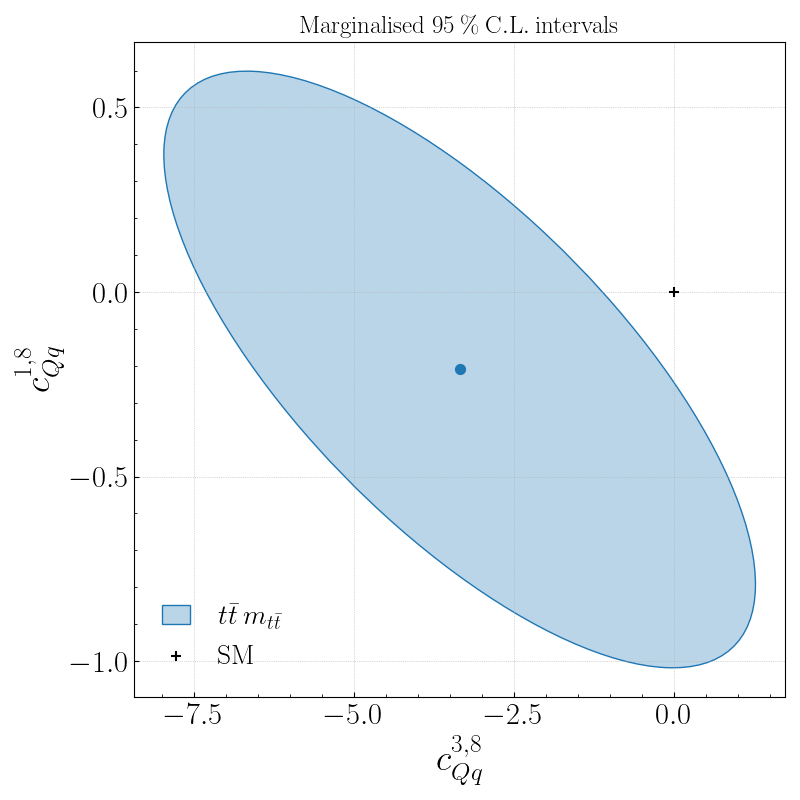

In [47]:
# show the exclusion contour
Image(filename='./reports/report_tt_mtt/contours_2d.png') 

**Question 2A**

- Can we exclude the SM?
- What special behaviour do you observe between the two operators and how does this compare to exercise 1?

Ultimately we should perform a combined fit of $ttV$ and $t\bar{t}\:(m_{t\bar{t}})$ data. Both are affected by the same four-fermion operators considered in this tutorial after all. 

**Question 2B**

- Modify the runcards yourself this time to run the combined fit
- Produce the exclusion contour

Hint: you should find

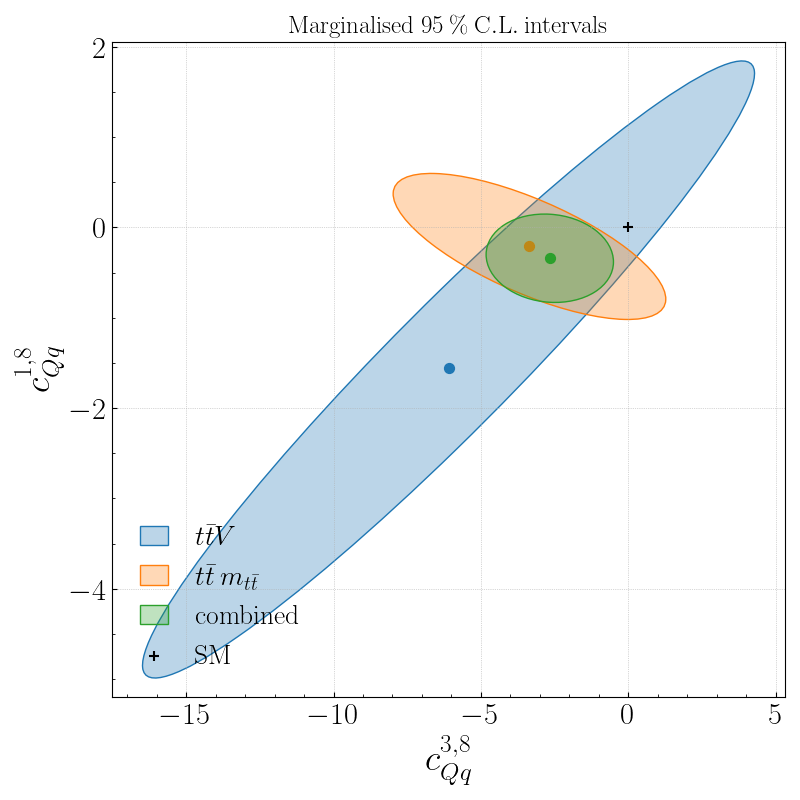

In [45]:
# show the exclusion contour
Image(filename='./reports/report_combined/contours_2d.png') 

**Question 2C**

- Comment on the interplay between the two classes of measurements
- What lesson do you take from this?

### Exercise 3 - quadratic fits (optional)

So far all the fits have been linear in the EFT expansion. In this last exercise you will study how the previous results change under the effect of quadratic EFT corrections. For this, you should set `use_quad: False` in the fit runcard and run the fit with `"A"` replaced by `"NS"`:

In [ ]:
#runner_ttV_quad = smefit.runner.Runner.from_file(pathlib.Path("./downloads/runcards/runcard_ttV_quadratic.yaml"))
#runner_ttV_quad.global_analysis("NS")